# RappiPay challenge for Data Scientists

This data analysisi report is submitted by *Luis G. Polanco Contreras*

Load the required modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import re
import ipywidgets as widgets
import sklearn.cluster as cluster

from fitter import Fitter, get_common_distributions, get_distributions

In [2]:
# Lets load the raw data to examine it and do the required data cleaning and preprocessing.

raw_df = pd.read_csv('ds_challenge_2021.csv')

raw_df.head()

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude
0,0,F,608.345634,2020-01-21,20,"{'model': 2020, 'device_score': 3, 'os': 'ANDR...",Super,Merida,Física,71000,51,Aceptada,False,60.834563,5.475111,False
1,0,F,88.719243,2020-01-15,7,"{'model': 2020, 'device_score': 1, 'os': 'ANDR...",NaN,Merida,Virtual,71000,51,Aceptada,False,0.000000,1.774385,False
2,1,F,790.037653,2020-01-17,11,"{'model': 2020, 'device_score': 1, 'os': '.'}",NaN,Guadalajara,Virtual,94000,56,En proceso,False,0.000000,15.800753,False
3,1,F,767.005387,2020-01-05,11,"{'model': 2020, 'device_score': 3, 'os': 'WEB'}",MPago,Guadalajara,Física,94000,56,Aceptada,False,0.000000,7.670054,False
4,1,F,254.171053,2020-01-30,10,"{'model': 2020, 'device_score': 3, 'os': '%%'}",NaN,Guadalajara,Física,94000,56,Aceptada,False,0.000000,2.541711,False


## Lets modify the 'dispositivo' column to be able to use its content

In [3]:
# First we will take the "Dispositivo" column and split its content into relevant columns.

dispositivo_df = pd.DataFrame(columns=['dispositivo_model','dispositivo_device_score','dispositivo_os'])

for (i,r) in raw_df.iterrows():
    e = r['dispositivo']
    a = [re.split(', |:', x) for x in e.split('\n')][0]
    dispositivo_df.loc[i] = [float(a[1]), float(a[3]), a[5][2:-2]]
    
data_df = pd.concat([raw_df, dispositivo_df], axis=1).drop(columns='dispositivo')

## We split the 'fecha' colums into three different columns.

In [4]:
# We need to convert the date into datetime format.

data_df['fecha'] = pd.to_datetime(data_df['fecha'])

In [5]:
# We'll split the datetime information into separate columns: year, month and day to more easily manipulate
# the information.

data_df['year'] = data_df['fecha'].dt.year
data_df['month'] = data_df['fecha'].dt.month
data_df['day'] = data_df['fecha'].dt.day

data_df = data_df.drop(columns='fecha')

In [6]:
# Lets find how many variables are  categorical and numerical and boolean.

# In total we have:
# - 12 numerical variables
# - 6 categorical variables
# - 2 boolean variables

data_df.dtypes

ID_USER                       int64
genero                       object
monto                       float64
hora                          int64
establecimiento              object
ciudad                       object
tipo_tc                      object
linea_tc                      int64
interes_tc                    int64
status_txn                   object
is_prime                       bool
dcto                        float64
cashback                    float64
fraude                         bool
dispositivo_model           float64
dispositivo_device_score    float64
dispositivo_os               object
year                          int64
month                         int64
day                           int64
dtype: object

## We will first explore the numerical features.

In [7]:
# Lets first do some basic statistical description of the numerical variables.

data_df.describe()

,ID_USER,monto,hora,linea_tc,interes_tc,dcto,cashback,dispositivo_model,dispositivo_device_score,year,month,day
count,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000,26975.0,26975.000000,26975.0,26975.0,26975.000000
mean,2003.765412,499.069493,11.987618,62476.811863,48.224875,17.466134,6.261186,2020.0,3.002595,2020.0,1.0,16.043855
std,1144.630736,289.309518,6.642565,21886.892902,9.587256,34.334566,4.458440,0.0,1.417432,0.0,0.0,8.382871
min,0.000000,0.017303,1.000000,25000.000000,32.000000,0.000000,0.000138,2020.0,1.000000,2020.0,1.0,2.000000
25%,1041.000000,246.521227,6.000000,44000.000000,40.000000,0.000000,2.791740,2020.0,2.000000,2020.0,1.0,9.000000
50%,2006.000000,500.501022,12.000000,62000.000000,48.000000,0.000000,5.636711,2020.0,3.000000,2020.0,1.0,16.000000
75%,2973.500000,749.598192,18.000000,82000.000000,57.000000,18.770710,8.531604,2020.0,4.000000,2020.0,1.0,23.000000
max,3999.000000,999.917764,23.000000,99000.000000,64.000000,199.356251,19.991582,2020.0,5.000000,2020.0,1.0,30.000000


/tmp/ipykernel_59655/3807845237.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  data_df.hist(ax=ax)


array([[<AxesSubplot:title={'center':'ID_USER'}>,
        <AxesSubplot:title={'center':'monto'}>,
        <AxesSubplot:title={'center':'hora'}>],
       [<AxesSubplot:title={'center':'linea_tc'}>,
        <AxesSubplot:title={'center':'interes_tc'}>,
        <AxesSubplot:title={'center':'dcto'}>],
       [<AxesSubplot:title={'center':'cashback'}>,
        <AxesSubplot:title={'center':'dispositivo_model'}>,
        <AxesSubplot:title={'center':'dispositivo_device_score'}>],
       [<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'day'}>]], dtype=object)

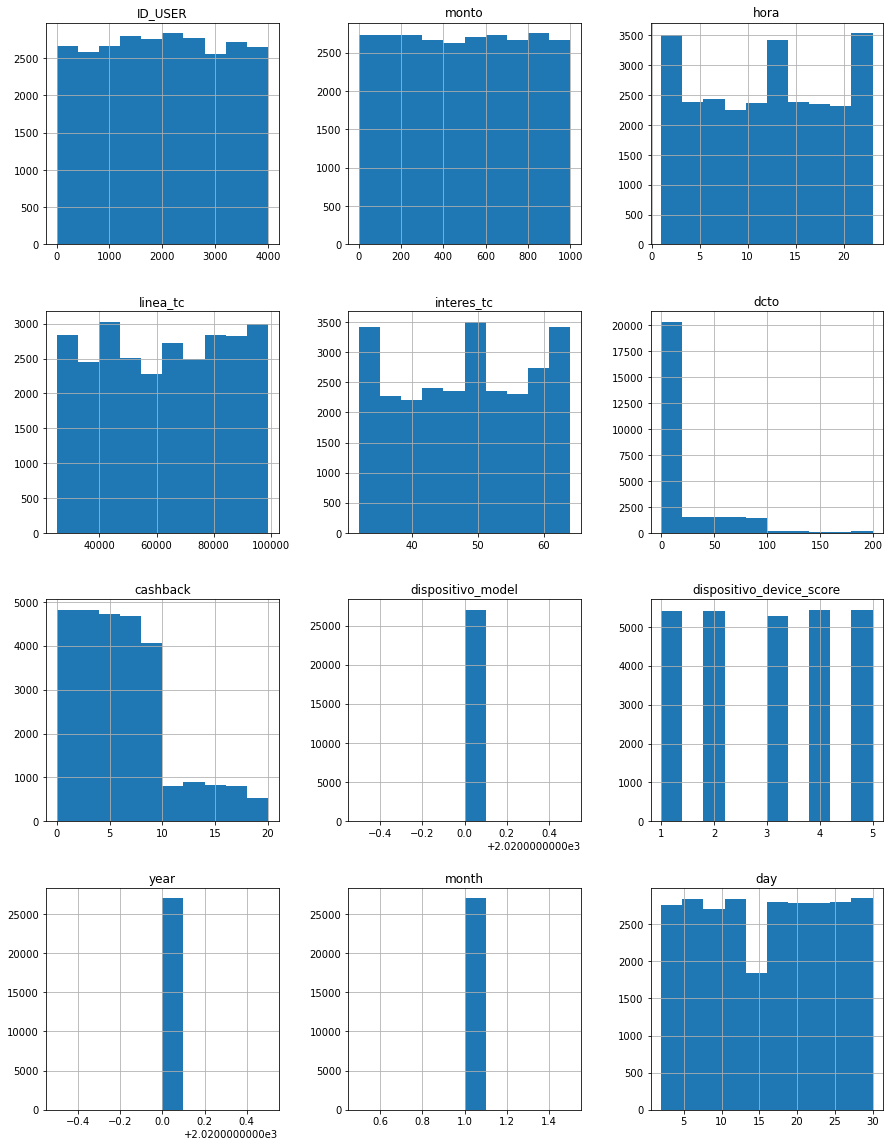

In [8]:
# We will plot histograms for these varialbles to get some visual information.
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data_df.hist(ax=ax)

We can make some basic observations from this description:

- 'dispositivo_model' has one unique entry corresponding to 2020.
- 'year' contains one single value, namely 2020.
- 'month' also contains a single value entry '1'.
- 'ID_USER', 'monto', 'linea_tc', 'dispositivo_device_score' appear to be uniformly distributed 
- 'dcto' and 'cashback' seem to follow an Alpha distribution.

ID_USER


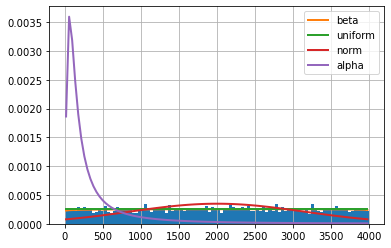

Best =  {'beta': {'a': 1.0233647018188217, 'b': 1.0153416397801123, 'loc': -0.008160287478027193, 'scale': 3999.02078206981}}

monto


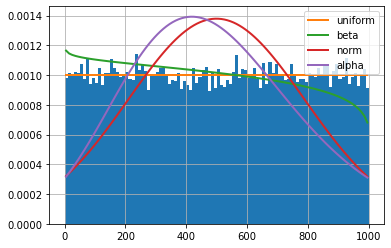

Best =  {'uniform': {'loc': 0.0173025133763937, 'scale': 999.9004611002038}}

hora


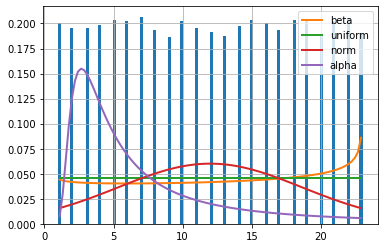

Best =  {'beta': {'a': 0.9494785606882844, 'b': 0.8353355163826299, 'loc': 0.7270508437854439, 'scale': 22.27294915621456}}

linea_tc


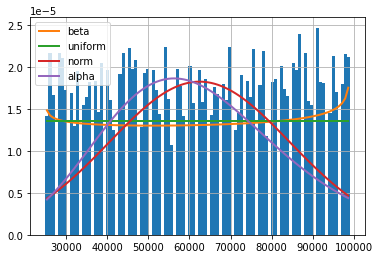

Best =  {'beta': {'a': 0.9622540190207302, 'b': 0.930625283513492, 'loc': 24999.502280440985, 'scale': 74000.49771955903}}

interes_tc


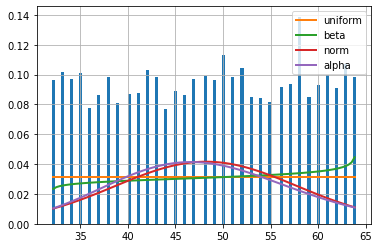

Best =  {'uniform': {'loc': 32.0, 'scale': 32.0}}

dcto


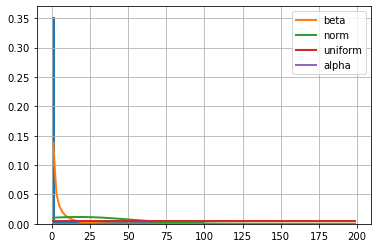

Best =  {'beta': {'a': 0.257833888541406, 'b': 157.8742590571851, 'loc': -1.32921390333443e-28, 'scale': 1921.7432338621352}}

cashback


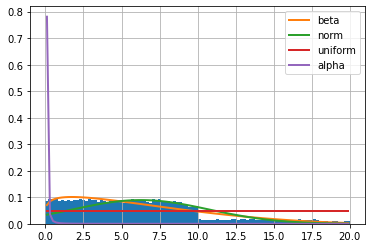

Best =  {'beta': {'a': 1.1853240202907496, 'b': 3.4344023946631, 'loc': -0.0007390051365510953, 'scale': 24.43185780336393}}

dispositivo_device_score


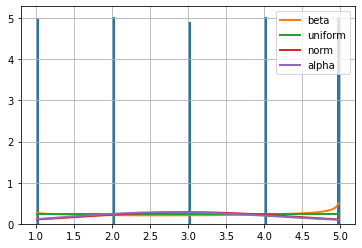

Best =  {'beta': {'a': 0.8301674674945463, 'b': 0.7853665275642647, 'loc': 0.7711690047457975, 'scale': 4.228830995254204}}

day


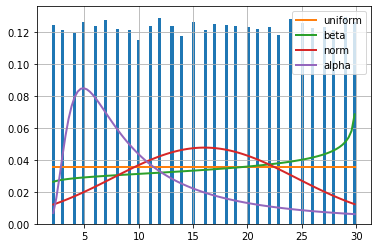

Best =  {'uniform': {'loc': 2.0, 'scale': 28.0}}



In [9]:
# Lets check the distrubutions we theorized above.
#
# The Fitter method attempts to find the best PDF (from a set list of functions) to the data provided using the 
# fit implementation is Scypy. The paramater for eah PDF are computed using MSE.

numeric_cols = ['ID_USER', 'monto', 'hora', 'linea_tc', 'interes_tc', 
                'dcto', 'cashback', 'dispositivo_device_score', 'day']

for name_col in numeric_cols:
    print(name_col)
    f = Fitter(data_df[name_col], distributions=['alpha', 'beta', 'norm', 'uniform'])
    f.fit()
    f.summary()
    plt.show()
    print('Best = ',f.get_best())
    print('')

In [10]:
def plot_fitted_dist(name_col):
    f = Fitter(data_df[name_col], distributions=['alpha', 'beta', 'norm', 'uniform'])
    f.fit()
    f.hist()
    f.plot_pdf()
    plt.title(name_col)
    plt.show()
    print('Best = ',f.get_best())
    print('')

In [11]:
criteria_rb = widgets.Dropdown(
    options=numeric_cols,
    value='ID_USER',
    description='Colunm:',
    disabled=False,
)

widgets.interact(plot_fitted_dist, name_col = criteria_rb)

interactive(children=(Dropdown(description='Colunm:', options=('ID_USER', 'monto', 'hora', 'linea_tc', 'intere…

<function __main__.plot_fitted_dist(name_col)>

Our initial hypothesis of some variable being uniform didn't get confirmed. But we found out that they distribute Beta for the most part. It is important to notice that for those variables which initial valorations was an unifor distribution, the parameters $\alpha$ and $\beta$ are quite close; whihc whill indeed resemble an uniform distribution while not being exact.

A similar phenomenon was experienced when analysisng the variables inicially though to behave as Alpha distributions. 

## Now lets explore the categorical variables.

In [12]:
cat_cols = ['genero', 'establecimiento', 'ciudad', 'tipo_tc', 'status_txn', 'dispositivo_os']

In [13]:
for name_col in cat_cols:
    print(data_df[name_col].value_counts())
    print('')

M     13519
F     10726
--     2730
Name: genero, dtype: int64

Restaurante    3454
Abarrotes      3415
Super          3402
MPago          3343
Farmacia       3242
Name: establecimiento, dtype: int64

Toluca         3997
Guadalajara    3833
Merida         3761
Monterrey      3706
Name: ciudad, dtype: int64

Física     18903
Virtual     8072
Name: tipo_tc, dtype: int64

Aceptada      18844
En proceso     5341
Rechazada      2790
Name: status_txn, dtype: int64

%%         6808
WEB        6766
.          6715
ANDROID    6686
Name: dispositivo_os, dtype: int64



We need to clear some of the data in this varialbes, specificaly :
- '--' entries in genero.
- '%%' and '.' entries in dispositivo_os.

In [14]:
data_df['genero'] = data_df['genero'].replace('--', 'NR')

In [15]:
data_df['dispositivo_os'] = data_df['dispositivo_os'].replace('%%', 'DISP1')
data_df['dispositivo_os'] = data_df['dispositivo_os'].replace('.', 'DISP2')

## To use categorical values we will convert them into numeric arrays.

With this method we will map ech categorical variable into $\mathbb{R}^n$, where $n$ is the number of categories in the given variable. We use this method since it will map the $i$-th category into $e_i \in \mathbb{R}^n$. This approach allow us to set a fixed distance between any 2 entries since $d(e_i, e_j) = \sqrt{2}$.

We expect this methodology to perform more reliale in most machine learning algorithms, since it doesn't modify the distance between entries.

In [16]:
for name_col in cat_cols:
    
    data_df = pd.concat([data_df, pd.get_dummies(data_df[name_col])], axis=1)
    data_df = data_df.drop(columns=name_col)
    
print(data_df)

       ID_USER       monto  hora  linea_tc  interes_tc  is_prime       dcto  \
0            0  608.345634    20     71000          51     False  60.834563   
1            0   88.719243     7     71000          51     False   0.000000   
2            1  790.037653    11     94000          56     False   0.000000   
3            1  767.005387    11     94000          56     False   0.000000   
4            1  254.171053    10     94000          56     False   0.000000   
...        ...         ...   ...       ...         ...       ...        ...   
26970     3999  746.192089    13     40000          56     False   0.000000   
26971     3999  941.804966    15     40000          56     False   0.000000   
26972     3999  251.189885    11     40000          56     False   0.000000   
26973     3999   24.182665    17     40000          56     False   2.418266   
26974     3999  517.209272    20     40000          56     False   0.000000   

        cashback  fraude  dispositivo_model  ...  T

## Now we will handle the boolean variable and convert them into int.

In [17]:
data_df['is_prime'] = data_df['is_prime'].astype(int)

data_df['is_prime'].value_counts()

0    23416
1     3559
Name: is_prime, dtype: int64

In [18]:
data_df['fraude'] = data_df['fraude'].astype(int)

data_df['fraude'].value_counts()

0    26165
1      810
Name: fraude, dtype: int64

# Categorized data set

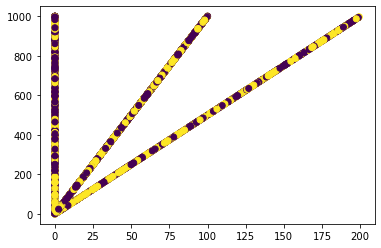

In [35]:
kmeans = cluster.KMeans(n_clusters=2, random_state=100).fit(data_df)
y_pred = kmeans.labels_

plt.scatter(data_df['dcto'], data_df['monto'], c=y_pred)

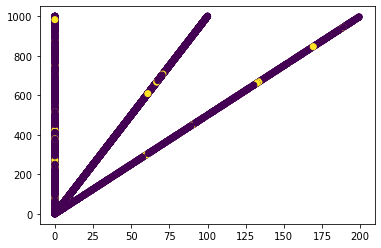

In [36]:
plt.scatter(data_df['dcto'], data_df['monto'], c=data_df['fraude'])